In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque


In [2]:
# Environment dimensions
AREA_WIDTH = 600
AREA_HEIGHT = 600

# Sensor and MC Parameters
NUM_SENSORS = 20
SENSOR_CAPACITY = 3000  # Joules
MC_CAPACITY = 1000000   # Joules (1000 kJ)
MC_SPEED = 5  # m/s
CHARGING_RATE = 150  # Joules per second  # CHANGED
MOVEMENT_COST_PER_M = 5  # Joules per meter  # CHANGED
THRESHOLD_RATIO = 0.3  # Time window opens when energy < 30% of capacity  # CHANGED


In [3]:
class SensorNode:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y
        self.capacity = SENSOR_CAPACITY
        self.energy = random.uniform(0.4, 0.8) * SENSOR_CAPACITY  # CHANGED: higher starting energy
        self.consumption_rate = random.uniform(0.2, 1.0)  # CHANGED: lower consumption rate
        self.dead = False
    
    def get_location(self):
        return (self.x, self.y)

    def update_energy(self, seconds):
        if not self.dead:
            self.energy -= self.consumption_rate * seconds
            if self.energy <= 0:
                self.energy = 0
                self.dead = True

    def needs_charging(self):
        return self.energy < (THRESHOLD_RATIO * self.capacity) and not self.dead

    def charge(self, amount):
        if not self.dead:
            self.energy += amount
            if self.energy > self.capacity:
                self.energy = self.capacity


In [4]:
class MobileCharger:
    def __init__(self, base_x=300, base_y=300):
        self.x = base_x
        self.y = base_y
        self.energy = MC_CAPACITY
        self.start_pos = (base_x, base_y)

    def move_to(self, x, y):
        distance = np.linalg.norm([self.x - x, self.y - y])
        cost = distance * MOVEMENT_COST_PER_M
        if self.energy < cost:
            return False  # not enough energy to move
        self.x, self.y = x, y
        self.energy -= cost
        return True

    def charge_node(self, node):
        if self.energy <= 0 or node.dead:
            return 0
        needed = node.capacity - node.energy
        time_to_charge = needed / CHARGING_RATE
        energy_to_transfer = min(needed, self.energy)
        node.charge(energy_to_transfer)
        self.energy -= energy_to_transfer
        return energy_to_transfer


In [5]:
def initialize_environment(num_sensors=NUM_SENSORS):
    sensors = []
    for i in range(num_sensors):
        x = random.uniform(0, AREA_WIDTH)
        y = random.uniform(0, AREA_HEIGHT)
        sensors.append(SensorNode(i, x, y))
    mc = MobileCharger()
    return sensors, mc


In [6]:
def plot_environment(sensors, mc):
    alive_x = [s.x for s in sensors if not s.dead]
    alive_y = [s.y for s in sensors if not s.dead]
    dead_x = [s.x for s in sensors if s.dead]
    dead_y = [s.y for s in sensors if s.dead]

    plt.figure(figsize=(8, 8))
    plt.scatter(alive_x, alive_y, c='green', label='Alive Sensors')
    plt.scatter(dead_x, dead_y, c='red', label='Dead Sensors')
    plt.scatter(mc.x, mc.y, c='blue', label='Mobile Charger (MC)', marker='X', s=100)
    plt.scatter(300, 300, c='black', label='Base Station', marker='s')
    plt.legend()
    plt.title("WRSN Environment")
    plt.grid(True)
    plt.xlim(0, AREA_WIDTH)
    plt.ylim(0, AREA_HEIGHT)
    plt.show()


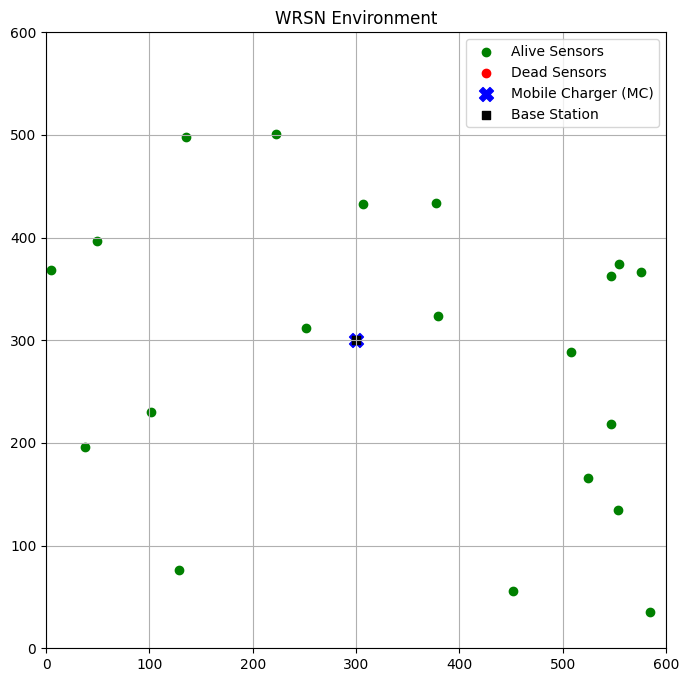

In [7]:
sensors, mc = initialize_environment()
plot_environment(sensors, mc)


In [8]:
def simulate_step(sensors, mc, time_step=10):
    # 1. Update energy of all sensors
    for s in sensors:
        s.update_energy(time_step)

    # 2. Filter sensors needing charging and still alive
    to_charge = [s for s in sensors if s.needs_charging()]
    if not to_charge:
        print("No sensor needs charging right now.")
        return False

    # 3. Select next sensor using greedy strategy (closest one)
    to_charge.sort(key=lambda s: np.linalg.norm([mc.x - s.x, mc.y - s.y]))
    target = to_charge[0]
    
    # 4. Move to sensor
    if not mc.move_to(target.x, target.y):
        print("MC does not have enough energy to move.")
        return False

    # 5. Charge the sensor
    charged_energy = mc.charge_node(target)
    print(f"Charged Sensor {target.id} with {charged_energy:.2f} J")

    return True


In [9]:
def run_simulation(sensors, mc, max_steps=1000, time_step=10, visualize_every=50):
    for step in range(max_steps):
        print(f"--- Step {step} ---")
        result = simulate_step(sensors, mc, time_step)
        if not result:
            print("Simulation ended (MC depleted or no tasks).")
            break

        if step % visualize_every == 0:
            plot_environment(sensors, mc)

    # Final stats
    dead = sum(1 for s in sensors if s.dead)
    alive = NUM_SENSORS - dead
    print(f"Simulation Complete. Alive: {alive}, Dead: {dead}")
    print(f"MC remaining energy: {mc.energy:.2f} J")


In [10]:
sensors, mc = initialize_environment()
run_simulation(sensors, mc, max_steps=200, time_step=15)


--- Step 0 ---
No sensor needs charging right now.
Simulation ended (MC depleted or no tasks).
Simulation Complete. Alive: 20, Dead: 0
MC remaining energy: 1000000.00 J


In [11]:
def get_state_vector(sensors, mc):
    state = []

    # 1. Global state: MC energy (normalized)
    mc_energy_ratio = mc.energy / MC_CAPACITY
    state.append(mc_energy_ratio)
    
    # 2. Add information about sensor distribution
    # Calculate center of mass of critical sensors
    critical_sensors = [s for s in sensors if s.needs_charging() and not s.dead]
    if critical_sensors:
        avg_x = sum(s.x for s in critical_sensors) / len(critical_sensors)
        avg_y = sum(s.y for s in critical_sensors) / len(critical_sensors)
        # Normalize and add to state
        state.extend([avg_x / AREA_WIDTH, avg_y / AREA_HEIGHT])
    else:
        state.extend([0.5, 0.5])  # Default to center if no critical sensors
    
    # 3. Add count of critical sensors
    critical_count = len(critical_sensors) / NUM_SENSORS  # Normalized
    state.append(critical_count)

    for s in sensors:
        # 4. Distance to the MC (normalized)
        distance = np.linalg.norm([mc.x - s.x, mc.y - s.y])
        max_dist = np.linalg.norm([AREA_WIDTH, AREA_HEIGHT])
        distance_norm = distance / max_dist

        # 5. Residual energy (normalized)
        energy_ratio = s.energy / s.capacity

        # 6. Time window status (1 if open, with urgency)
        if s.dead:
            window_open = 0
        elif s.energy < 0.1 * s.capacity:  # Critical
            window_open = 2  # Higher urgency signal
        elif s.needs_charging():
            window_open = 1
        else:
            window_open = 0

        # 7. Time left before death (normalized)
        if s.dead or s.consumption_rate == 0:
            time_left_ratio = 0
        else:
            time_left = s.energy / s.consumption_rate
            time_left_ratio = min(time_left / 1000, 1)  # cap to avoid large numbers

        # Append sensor state
        state += [distance_norm, energy_ratio, window_open, time_left_ratio]

    return np.array(state, dtype=np.float32)

In [12]:
sensors, mc = initialize_environment()
state = get_state_vector(sensors, mc)

print(f"State vector shape: {state.shape}")
print(f"Sample values:\n{state[:10]} ...")


State vector shape: (84,)
Sample values:
[1.         0.5        0.5        0.         0.32282522 0.7786996
 0.         1.         0.22499068 0.58636916] ...


In [13]:
sensors, mc = initialize_environment()


In [14]:
def get_valid_actions(sensors, mc):
    actions = []
    for i, sensor in enumerate(sensors):
        if sensor.needs_charging() and not sensor.dead:
            actions.append(i)
    actions.append(NUM_SENSORS)  # action to return to base
    return actions


In [15]:
def explain_action(action):
    if action == NUM_SENSORS:
        return "Return to base station"
    else:
        return f"Charge sensor {action}"


In [16]:
sensors, mc = initialize_environment()
valid_actions = get_valid_actions(sensors, mc)

print("Valid actions:", valid_actions)
for a in valid_actions:
    print(f"Action {a}: {explain_action(a)}")


Valid actions: [20]
Action 20: Return to base station


In [17]:
def calculate_reward(prev_dead_count, curr_dead_count, distance_moved, charged_amount=0, sensor_energy_ratio=0):
    move_penalty = - (distance_moved / 20)  # Reduced movement penalty
    new_deaths = curr_dead_count - prev_dead_count
    death_penalty = new_deaths * -50         # Increased from -20 to -50
    
    # Add reward based on criticality of charged sensor
    charging_reward = 0
    if charged_amount > 0:
        # Higher reward for charging critical sensors
        if sensor_energy_ratio < 0.2:
            charging_reward = 20
        elif sensor_energy_ratio < 0.5:
            charging_reward = 10
        else:
            charging_reward = 5
    
    return move_penalty + death_penalty + charging_reward

In [18]:
def count_dead_sensors(sensors):
    return sum(1 for s in sensors if s.dead)


In [19]:
sensors, mc = initialize_environment()

prev_dead = count_dead_sensors(sensors)

# Simulate one step manually
target = sensors[5]
distance = np.linalg.norm([mc.x - target.x, mc.y - target.y])
mc.move_to(target.x, target.y)
mc.charge_node(target)

# Simulate energy drop
for s in sensors:
    s.update_energy(30)

curr_dead = count_dead_sensors(sensors)

reward = calculate_reward(prev_dead, curr_dead, distance)
print(f"Reward: {reward:.2f}")


Reward: -12.31


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_dim=256):  # Increased from 128 to 256
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim // 2)  # Add another layer
        self.out = nn.Linear(hidden_dim // 2, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))  # New layer
        return self.out(x)


In [21]:
from collections import deque
import random

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))

        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.long),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32)
        )

    def __len__(self):
        return len(self.buffer)


In [22]:
class DQNAgent:
    def __init__(self, state_size, action_size, lr=5e-4, gamma=0.99, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.q_network = QNetwork(state_size, action_size)
        self.target_network = QNetwork(state_size, action_size)
        self.target_network.load_state_dict(self.q_network.state_dict())  # sync weights

        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        self.replay_buffer = ReplayBuffer()

    def act(self, state, valid_actions, sensors=None, mc=None):
        if np.random.rand() < self.epsilon:
            # Use prioritized actions for smarter exploration if sensors and mc provided
            if sensors is not None and mc is not None:
                prioritized_actions = get_prioritized_actions(sensors, mc)
                # Only consider valid actions
                valid_prioritized = [a for a in prioritized_actions if a in valid_actions]
                return valid_prioritized[0] if valid_prioritized else random.choice(valid_actions)
            else:
                return random.choice(valid_actions)  # Regular random if sensors/mc not provided
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            q_values = q_values.squeeze().detach().numpy()

            # Mask invalid actions
            masked_q = np.full(self.action_size, -np.inf)
            masked_q[valid_actions] = q_values[valid_actions]

            return int(np.argmax(masked_q))  # Exploit best valid action

    def train(self, batch_size=64):
        if len(self.replay_buffer) < batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)

        # Compute target Q-values
        with torch.no_grad():
            next_q_vals = self.target_network(next_states).max(1)[0]
            targets = rewards + (1 - dones) * self.gamma * next_q_vals

        current_q_vals = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()

        loss = self.loss_fn(current_q_vals, targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


In [23]:
# Create network instance
sensors, mc = initialize_environment()  # Make sure this is run before agent creation
state_size = len(get_state_vector(sensors, mc))  # Dynamically calculate state size
action_size = NUM_SENSORS + 1  # Include "return to base"
agent = DQNAgent(state_size, action_size)

# Dummy state
dummy_state = get_state_vector(sensors, mc)
dummy_state_tensor = torch.tensor(dummy_state, dtype=torch.float32).unsqueeze(0)  # batch of 1

q_values = agent.q_network(dummy_state_tensor)  # Use the agent's q_network
print("Q-values shape:", q_values.shape)
print("Q-values:", q_values)


Q-values shape: torch.Size([1, 21])
Q-values: tensor([[ 0.0064,  0.0563,  0.0129, -0.0429, -0.0687, -0.0850, -0.0274, -0.0640,
         -0.0453,  0.0030,  0.1130, -0.0390, -0.0023, -0.0494, -0.0399, -0.0334,
          0.0059, -0.0380, -0.0220, -0.0090,  0.0752]],
       grad_fn=<AddmmBackward0>)


In [24]:
state_size = 1 + NUM_SENSORS * 4
action_size = NUM_SENSORS + 1
agent = DQNAgent(state_size, action_size)

state = get_state_vector(sensors, mc)
valid_actions = get_valid_actions(sensors, mc)

action = agent.act(state, valid_actions)
print(f"Agent chose action: {action}")


Agent chose action: 20


In [25]:
def evaluate_agent(agent, episodes=5, max_steps=200, time_step=30):
    print("\n--- Evaluation Mode (Epsilon = 0.0) ---")
    agent.epsilon = 0.0  # greedy policy
    results = []

    for ep in range(episodes):
        sensors, mc = initialize_environment()
        state = get_state_vector(sensors, mc)
        total_reward = 0
        dead_before = count_dead_sensors(sensors)

        print(f"\nEpisode {ep+1}:")

        for step in range(max_steps):
            valid_actions = get_valid_actions(sensors, mc)
            if not valid_actions:
                print(f"  Step {step}: No valid actions left.")
                break

            action = agent.act(state, valid_actions)
            action_desc = explain_action(action)
            print(f"  Step {step}: Action {action} → {action_desc}")

            if action == NUM_SENSORS:
                mc.move_to(300, 300)
                mc.energy = MC_CAPACITY
                reward = -0.1
                next_state = get_state_vector(sensors, mc)
            else:
                target = sensors[action]
                distance = np.linalg.norm([mc.x - target.x, mc.y - target.y])
                move_ok = mc.move_to(target.x, target.y)

                if not move_ok:
                    reward = -5
                    break
                else:
                    charged = mc.charge_node(target)

                    for s in sensors:
                        s.update_energy(time_step)

                    dead_after = count_dead_sensors(sensors)
                    reward = calculate_reward(dead_before, dead_after, distance)
                    if charged > 0:
                        reward += 5.0

                    dead_before = dead_after
                    next_state = get_state_vector(sensors, mc)

            state = next_state
            total_reward += reward

        dead_final = count_dead_sensors(sensors)
        print(f"Episode {ep+1} Complete → Total Reward: {total_reward:.2f}, Dead Sensors: {dead_final}")
        charged_count = sum(1 for s in sensors if s.energy > 0.95 * s.capacity)
        print(f"  Sensors fully charged: {charged_count}")

        results.append((total_reward, dead_final))

    return results


In [26]:
def train_dqn(agent, episodes=500, max_steps=200, batch_size=64, target_update=5):
    episode_rewards = []

    for ep in range(episodes):
        sensors, mc = initialize_environment()
        state = get_state_vector(sensors, mc)
        total_reward = 0
        done = False
        dead_before = count_dead_sensors(sensors)

        for step in range(max_steps):
            valid_actions = get_valid_actions(sensors, mc)
            if not valid_actions:
                print(f"  Step {step}: No valid actions available.")
                break

            action = agent.act(state, valid_actions)
            action_desc = explain_action(action)
            print(f"  Step {step}: Action {action} → {action_desc}")

            # --- Execute action ---
            if action == NUM_SENSORS:
                mc.move_to(300, 300)
                mc.energy = MC_CAPACITY
                reward = -0.5  # Reduced base return penalty
                next_state = get_state_vector(sensors, mc)
                done = False
            else:
                target = sensors[action]
                distance = np.linalg.norm([mc.x - target.x, mc.y - target.y])
                move_ok = mc.move_to(target.x, target.y)

                if not move_ok:
                    reward = -5
                    done = True
                else:
                    charged = mc.charge_node(target)
                    energy_ratio = target.energy / target.capacity

                    # Simulate energy drain with smaller time step for more gradual changes
                    for s in sensors:
                        s.update_energy(15)  # Reduced from 30 to 15

                    dead_after = count_dead_sensors(sensors)
                    reward = calculate_reward(dead_before, dead_after, distance, charged, energy_ratio)

                    dead_before = dead_after
                    done = mc.energy <= 0 or dead_after == NUM_SENSORS

                next_state = get_state_vector(sensors, mc)

            # Store and train
            agent.replay_buffer.push(state, action, reward, next_state, done)
            agent.train(batch_size)

            state = next_state
            total_reward += reward

            if done:
                break


        agent.decay_epsilon()

        # Periodically update target network
        if ep % target_update == 0:
            agent.update_target_network()

        # Final episode-level bonus
        if not done and dead_before == 0:
            total_reward += 25  # bonus for keeping all sensors alive

        # Log results
        dead_now = count_dead_sensors(sensors)
        print(f"Episode {ep+1}/{episodes} - Reward: {total_reward:.2f}, Dead: {dead_now}, Epsilon: {agent.epsilon:.3f}")

        episode_rewards.append(total_reward)

    return episode_rewards


In [27]:
def get_prioritized_actions(sensors, mc):
    """Return actions sorted by priority based on sensor criticality"""
    actions_with_priority = []
    
    for i, sensor in enumerate(sensors):
        if sensor.needs_charging() and not sensor.dead:
            # Calculate priority based on:
            # 1. Energy level (lower = higher priority)
            # 2. Distance (closer = higher priority)
            distance = np.linalg.norm([mc.x - sensor.x, mc.y - sensor.y])
            energy_ratio = sensor.energy / sensor.capacity
            time_to_death = sensor.energy / sensor.consumption_rate if sensor.consumption_rate > 0 else float('inf')
            
            # Priority score (lower is better)
            priority = time_to_death + (distance / 100)
            
            actions_with_priority.append((i, priority))
    
    # Sort by priority (lower score = higher priority)
    actions_with_priority.sort(key=lambda x: x[1])
    
    # Extract just the actions
    prioritized_actions = [a[0] for a in actions_with_priority]
    
    # Add return to base as lowest priority
    prioritized_actions.append(NUM_SENSORS)
    
    return prioritized_actions

In [28]:
# Dynamically calculate the correct state size based on the actual state vector
sensors, mc = initialize_environment()  # Ensure the environment is initialized
state_size = len(get_state_vector(sensors, mc))  # Correct state size
action_size = NUM_SENSORS + 1
agent = DQNAgent(state_size, action_size)

rewards = train_dqn(agent, episodes=100)

  Step 0: Action 20 → Return to base station
  Step 1: Action 20 → Return to base station
  Step 2: Action 20 → Return to base station
  Step 3: Action 20 → Return to base station
  Step 4: Action 20 → Return to base station
  Step 5: Action 20 → Return to base station
  Step 6: Action 20 → Return to base station
  Step 7: Action 20 → Return to base station
  Step 8: Action 20 → Return to base station
  Step 9: Action 20 → Return to base station
  Step 10: Action 20 → Return to base station
  Step 11: Action 20 → Return to base station
  Step 12: Action 20 → Return to base station
  Step 13: Action 20 → Return to base station
  Step 14: Action 20 → Return to base station
  Step 15: Action 20 → Return to base station
  Step 16: Action 20 → Return to base station
  Step 17: Action 20 → Return to base station
  Step 18: Action 20 → Return to base station
  Step 19: Action 20 → Return to base station
  Step 20: Action 20 → Return to base station
  Step 21: Action 20 → Return to base statio

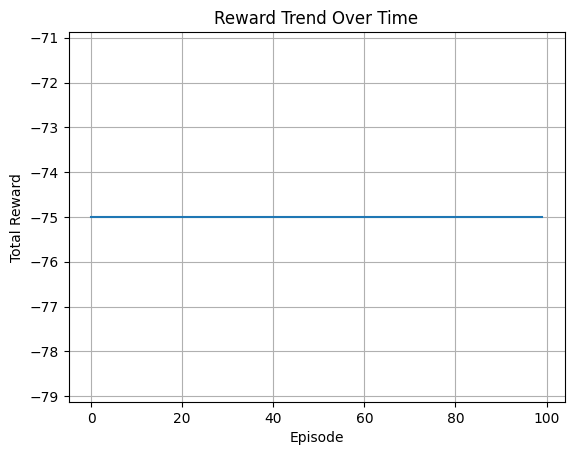

In [29]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Reward Trend Over Time")
plt.grid(True)
plt.show()


In [30]:
# Step 3: Evaluate the trained agent
results = evaluate_agent(agent, episodes=3)


--- Evaluation Mode (Epsilon = 0.0) ---

Episode 1:
  Step 0: Action 20 → Return to base station
  Step 1: Action 20 → Return to base station
  Step 2: Action 20 → Return to base station
  Step 3: Action 20 → Return to base station
  Step 4: Action 20 → Return to base station
  Step 5: Action 20 → Return to base station
  Step 6: Action 20 → Return to base station
  Step 7: Action 20 → Return to base station
  Step 8: Action 20 → Return to base station
  Step 9: Action 20 → Return to base station
  Step 10: Action 20 → Return to base station
  Step 11: Action 20 → Return to base station
  Step 12: Action 20 → Return to base station
  Step 13: Action 20 → Return to base station
  Step 14: Action 20 → Return to base station
  Step 15: Action 20 → Return to base station
  Step 16: Action 20 → Return to base station
  Step 17: Action 20 → Return to base station
  Step 18: Action 20 → Return to base station
  Step 19: Action 20 → Return to base station
  Step 20: Action 20 → Return to base

In [31]:
# Step 4: Print average performance
rewards_eval, deaths_eval = zip(*results)
print("\n--- Evaluation Summary ---")
print("Average Evaluation Reward:", np.mean(rewards_eval))
print("Average Dead Sensors:", np.mean(deaths_eval))


--- Evaluation Summary ---
Average Evaluation Reward: -20.000000000000014
Average Dead Sensors: 0.0


In [32]:
def visualize_charger_operation(agent, max_steps=200, time_step=30):
    # Initialize environment
    sensors, mc = initialize_environment()
    
    # Record data
    mc_positions = [(mc.x, mc.y)]  # Start with initial position
    energy_levels = [[s.energy for s in sensors]]
    charging_events = []  # Will contain (step, sensor_id, x, y) tuples
    alive_counts = [sum(1 for s in sensors if not s.dead)]
    
    # Simulation loop
    state = get_state_vector(sensors, mc)
    
    for step in range(max_steps):
        valid_actions = get_valid_actions(sensors, mc)
        if not valid_actions:
            break
            
        action = agent.act(state, valid_actions)
        
        # Record before action
        prev_energy = [s.energy for s in sensors]
        
        # Execute action
        if action == NUM_SENSORS:  # Return to base
            mc.move_to(300, 300)
            mc.energy = MC_CAPACITY
        else:
            target = sensors[action]
            mc.move_to(target.x, target.y)
            charged = mc.charge_node(target)
            
            if charged > 0:
                charging_events.append((step, action, mc.x, mc.y))
        
        # Record after action
        mc_positions.append((mc.x, mc.y))
        
        # Update all sensors
        for s in sensors:
            s.update_energy(time_step)
            
        # Record energy levels and alive count
        energy_levels.append([s.energy for s in sensors])
        alive_counts.append(sum(1 for s in sensors if not s.dead))
        
        # Update state
        state = get_state_vector(sensors, mc)
    
    # Create visualizations
    plt.figure(figsize=(15, 12))
    
    # 1. Plot the final state of the environment with charger path
    plt.subplot(2, 2, 1)
    alive_x = [s.x for s in sensors if not s.dead]
    alive_y = [s.y for s in sensors if not s.dead]
    dead_x = [s.x for s in sensors if s.dead]
    dead_y = [s.y for s in sensors if s.dead]
    
    plt.scatter(alive_x, alive_y, c='green', label='Alive Sensors')
    plt.scatter(dead_x, dead_y, c='red', label='Dead Sensors')
    
    # Plot charger path
    path_x, path_y = zip(*mc_positions)
    plt.plot(path_x, path_y, 'b-', label='MC Path', alpha=0.5)
    plt.scatter(path_x[0], path_y[0], c='black', label='Start', marker='o', s=100)
    plt.scatter(path_x[-1], path_y[-1], c='blue', label='End', marker='X', s=100)
    
    # Plot charging events
    if charging_events:
        ce_step, ce_id, ce_x, ce_y = zip(*charging_events)
        plt.scatter(ce_x, ce_y, c='yellow', label='Charging Events', marker='*', s=200, alpha=0.7)
    
    plt.legend()
    plt.title("Mobile Charger Path and Charging Events")
    plt.grid(True)
    plt.xlim(0, AREA_WIDTH)
    plt.ylim(0, AREA_HEIGHT)
    
    # 2. Plot energy levels of a few representative sensors
    plt.subplot(2, 2, 2)
    sample_sensors = min(5, NUM_SENSORS)  # Show up to 5 sensors
    for i in range(sample_sensors):
        sensor_energy = [levels[i] for levels in energy_levels]
        plt.plot(sensor_energy, label=f'Sensor {i}')
    
    plt.axhline(y=THRESHOLD_RATIO * SENSOR_CAPACITY, color='r', linestyle='--', label='Charging Threshold')
    plt.legend()
    plt.title("Energy Levels of Sample Sensors")
    plt.xlabel("Steps")
    plt.ylabel("Energy (J)")
    plt.grid(True)
    
    # 3. Plot alive sensors count
    plt.subplot(2, 2, 3)
    plt.plot(alive_counts, 'g-')
    plt.title("Number of Alive Sensors Over Time")
    plt.xlabel("Steps")
    plt.ylabel("Alive Sensors")
    plt.grid(True)
    
    # 4. Plot charging events over time
    plt.subplot(2, 2, 4)
    if charging_events:
        plt.scatter(ce_step, ce_id, c='orange', s=100, marker='o')
        plt.title("Charging Events Timeline")
        plt.xlabel("Step")
        plt.ylabel("Sensor ID")
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, "No charging events recorded", ha='center', va='center')
        plt.title("Charging Events Timeline")
    
    plt.tight_layout()
    plt.show()
    
    return sensors, mc, mc_positions, charging_events

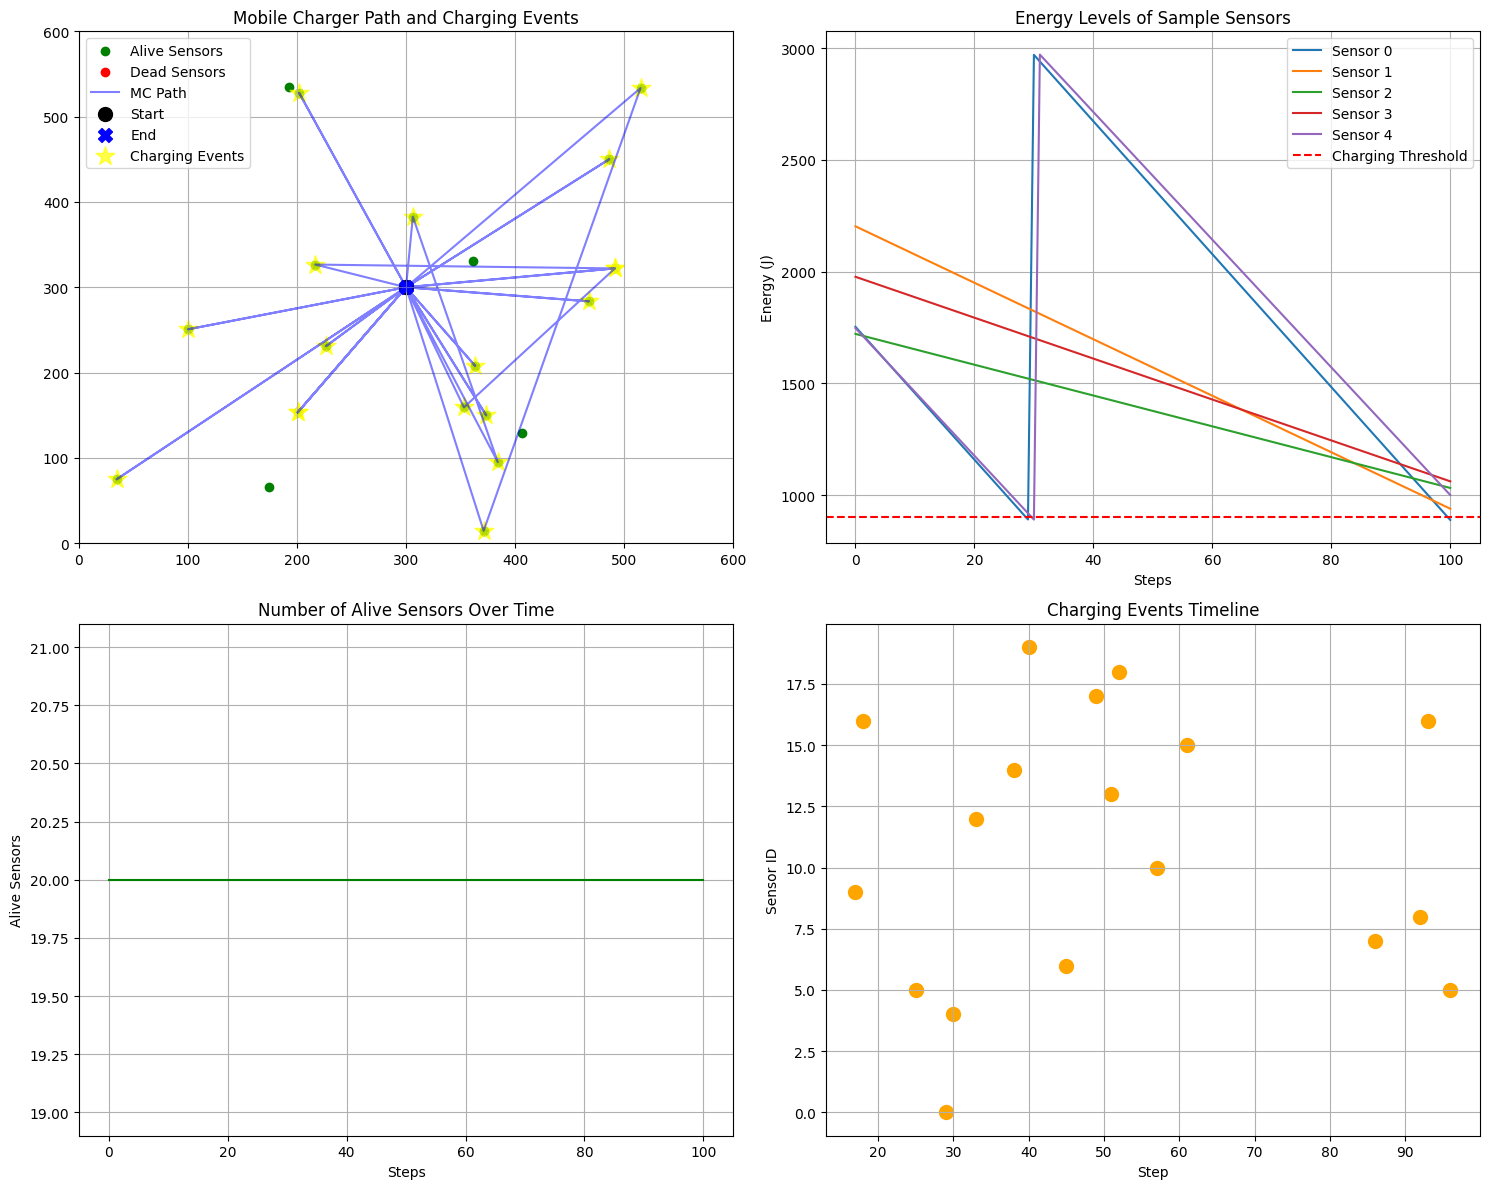

([<__main__.SensorNode at 0x262ff735c90>,
 [(300, 300),
  (300, 300),
  (300, 300),
  (300, 300),
  (300, 300),
  (300, 300),
  (300, 300),
  (300, 300),
  (300, 300),
  (300, 300),
  (300, 300),
  (300, 300),
  (300, 300),
  (300, 300),
  (300, 300),
  (300, 300),
  (300, 300),
  (300, 300),
  (216.7780178529592, 326.61678152885696),
  (491.55473084054387, 322.09749955873474),
  (300, 300),
  (300, 300),
  (300, 300),
  (300, 300),
  (300, 300),
  (300, 300),
  (200.67455579284572, 153.3722796430732),
  (300, 300),
  (300, 300),
  (300, 300),
  (371.16467607399056, 14.567314881537218),
  (515.0520300241624, 533.4824786418225),
  (300, 300),
  (300, 300),
  (201.98937137249536, 527.8566965000958),
  (300, 300),
  (300, 300),
  (300, 300),
  (300, 300),
  (373.5273590552695, 149.99411423021763),
  (300, 300),
  (363.34493765348236, 208.0533660708819),
  (300, 300),
  (300, 300),
  (300, 300),
  (300, 300),
  (34.68278782754339, 74.98587766670435),
  (300, 300),
  (300, 300),
  (300, 300

In [33]:
# Run visualization of charger operation
visualize_charger_operation(agent, max_steps=100)